In [1]:
# BiocManager::install("philr")
# BiocManager::install("phyloseq")
# install.packages("phytools")
# install.packages("ggdendro")
# install.packages("RColorBrewer")

In [2]:
library(philr)
library(phyloseq)
library(ape)
library(phytools)
library(ggplot2)
library(gridExtra)
library(ggdendro)
library(RColorBrewer)
library(vegan)

Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

Loading required package: maps

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2


Attaching package: ‘vegan’


The following object is masked from ‘package:phytools’:

    scores




In [3]:
# seqtab <- read.table("../01-read_processing/sequence_table.merged.txt", header=T, row.names=1)
# tax <- read.table("../01-read_processing/taxonomy_bac.txt", header=F, row.names=1, sep="\t")
# tree <- read.tree("../01-read_processing/rep_set.align.tre")
# tree.root <- midpoint.root(tree)
load("../02-diversity_analyses/.RData")

In [4]:
# read in siblings map, replace ps.dat map
map <- read.table("merged_sibs.txt", sep="\t", header=T, row.names=3)
sample_data(ps.dat) <- sample_data(map)
head(sample_data(ps.dat))
ps.dat

,Sibling_group_number,Study_ID,study_id,aliquot_type,sex,age_y,study_group,FDI_code,oral_health,tooth_health,tooth_type,tooth_age
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
DM00009V1PQ65,1,DM00009,DM00009,CF-PF,F,3,HUU,65,CF,PF,premolar,primary
DM00010V1PQ54,1,DM00010,DM00010,CF-PF,M,5,HUU,54,CF,PF,premolar,primary
DM00021V1PQ11-12-1,2,DM00021,DM00021,CA-PF,M,6,HEU,11,CA,PF,incisor,adult
DM00021V1PQ31-41-1,2,DM00021,DM00021,CA-PF,M,6,HEU,31,CA,PF,incisor,adult
DM00021V1PQ55-1,2,DM00021,DM00021,CA-PD,M,6,HEU,55,CA,PD,premolar,primary
DM00021V1PQ65-1,2,DM00021,DM00021,CA-PD,M,6,HEU,65,CA,PD,premolar,primary


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2918 taxa and 77 samples ]
sample_data() Sample Data:       [ 77 samples by 12 sample variables ]
tax_table()   Taxonomy Table:    [ 2918 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2918 tips and 2917 internal nodes ]

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Warning message:
“Removed 10 row(s) containing missing values (geom_path).”
Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse

Warning message:
“Removed 10 row(s) containing missing values (geom_path).”


pdf 
  2

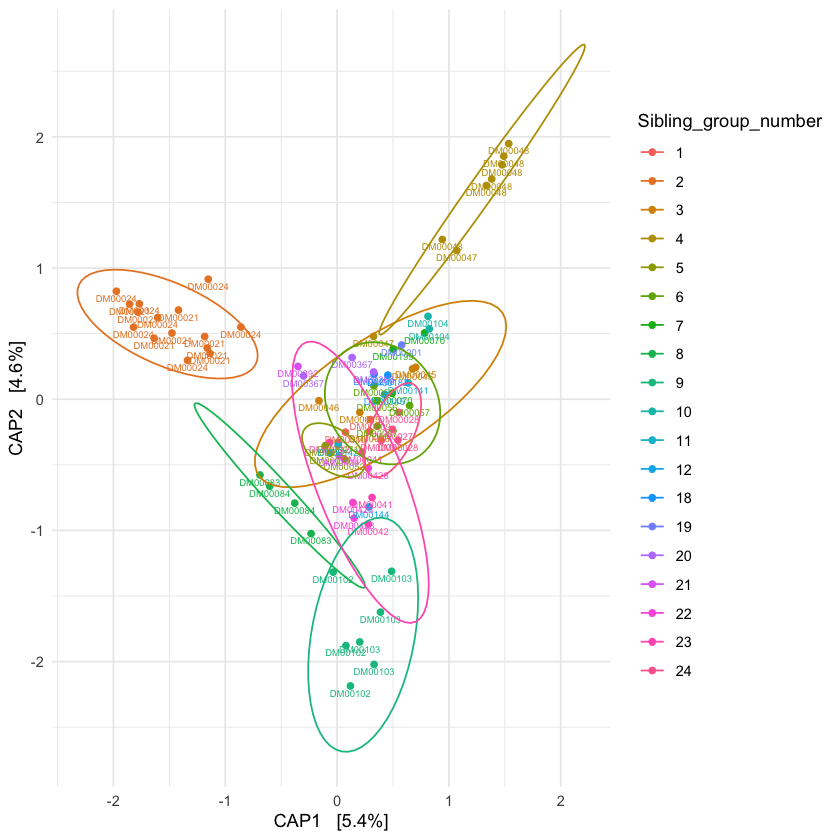

In [5]:
# plot betadiversity
sample_data(ps.dat)$Sibling_group_number <- as.factor(sample_data(ps.dat)$Sibling_group_number)
ordcap <- ordinate(ps.dat, "CAP", "bray", ~Sibling_group_number)
bdiv <- plot_ordination(ps.dat, ordcap, "samples", color="Sibling_group_number", label="study_id") + theme_minimal()
bdiv <- bdiv + stat_ellipse(type="t")
bdiv
pdf("siblings_bdiv.pdf")
bdiv
dev.off()

In [11]:
# philr transformation for heirarchical clustering dendrogram
philr.dat <- transform_sample_counts(ps.dat, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...



pdf 
  2

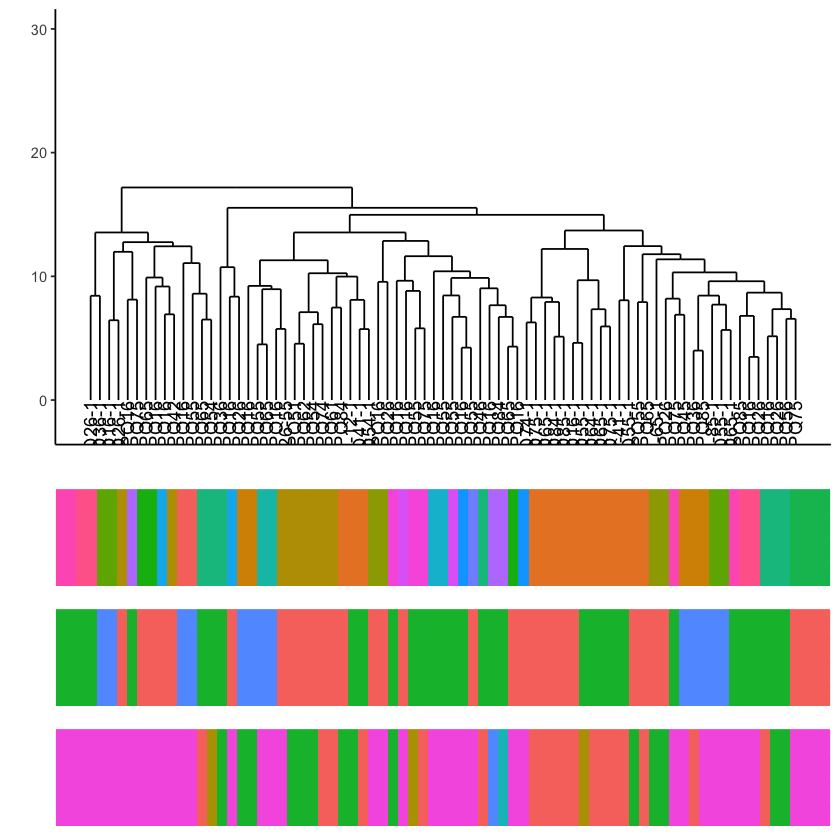

In [7]:
hc <- hclust(dist(philr.t), method="complete")
df2 <- data.frame(cluster=cutree(hc,5), states=factor(hc$labels, levels=hc$labels[hc$order])) # get cluster assocaited with each sample
write.table(df2, "philr_cluster.txt", quote=F, sep="\t", col.names=NA)

hcd <- as.dendrogram(hc)
dend_data <- dendro_data(hcd, type="rectangle")
p1 <- ggplot(dend_data$segments) + geom_segment(aes(x=x,y=y, xend=xend, yend=yend)) + theme_classic() + geom_text(data = dend_data$labels, aes(x, y, label = label, hjust = 1, angle = 90)) + ylim(-2,30) + xlab("") + ylab("") + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) 
merge <- merge(df2, map, by.x=c("states"), by.y=0)
p2 <- ggplot(merge, aes(states, y=1, fill=factor(Sibling_group_number))) + geom_tile() + scale_y_continuous(expand=c(0,0)) + theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.text=element_blank(), legend.position="none")
p3 <- ggplot(merge, aes(states, y=1, fill=factor(study_group))) + geom_tile() + scale_y_continuous(expand=c(0,0)) + theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.text=element_blank(), legend.position="none")
p4 <- ggplot(merge, aes(states, y=1, fill=factor(aliquot_type))) + geom_tile() + scale_y_continuous(expand=c(0,0)) + theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.text=element_blank(), legend.position="none")

gp1<-ggplotGrob(p1)
gp2<-ggplotGrob(p2)
gp3<-ggplotGrob(p3)
gp4<-ggplotGrob(p4)
maxWidth <- grid::unit.pmax(gp1$widths[2:5], gp2$widths[2:5])
gp1$widths[2:5] <- as.list(maxWidth)
gp2$widths[2:5] <- as.list(maxWidth)
gp3$widths[2:5] <- as.list(maxWidth)
gp4$widths[2:5] <- as.list(maxWidth)
pdf("sibs_dendrogram.pdf")
grid.arrange(gp1, gp2, gp3, gp4, ncol=1,heights=c(4/5,1/5,1/5,1/5))
dev.off()

grid.arrange(gp1, gp2, gp3, gp4, ncol=1,heights=c(4/5,1/5,1/5,1/5))

In [38]:
metadata <- as(sample_data(philr.dat), "data.frame")
philr.dist <- dist(philr.t, method="euclidean")
# what variables are significant after controlling for samples collected from the same individual?
adonis2(philr.dist ~ study_id + Sibling_group_number + aliquot_type + study_group, data=metadata, by="margin")

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
study_id,14,9.073147e+02,1.987653e-01,2.143789,0.001
Sibling_group_number,0,-6.821210e-13,-1.494322e-16,-Inf,NA
aliquot_type,4,1.674809e+02,3.669002e-02,1.385024,0.026
study_group,0,-6.821210e-13,-1.494322e-16,-Inf,NA
Residual,38,1.148765e+03,2.516599e-01,NA,NA
Total,76,4.564753e+03,1.000000e+00,NA,NA
